<font size="5" color="#2874a6">Reinforcement Learning with Q-learning</font>

In [126]:
%reset -f

## Environment

In [127]:
# Base Environment class
class Environment:
    def __init__(self, shape, landmarks: list = None):
        self.shape = shape
        self.landmarks = landmarks
        self.reset()
    
    def reset(self):
        """Defines and resets the entire state space."""
        self.state = None
        return self.state

    def step(self, action):
        """Defines the next state and reward regarding to an action at current state."""
        reward, done = None, False
        return self.state, reward, done

In [128]:
from typing import Literal, get_args

# Movement types
_MOVETYPES = Literal["up", "down", "left", "right"]

# Obstacle types
_OBSTACLES = Literal["river", "swamp", "mountain"]

# Terrain costs configuration
TERRAIN_COSTS = {
    'free': -0.1,      # Basis-Bewegungskosten
    'river': -0.5,     # 5x teurer als normal
    'swamp': -0.8,     # 8x teurer
    'mountain': -1.5,  # 15x teurer
}
GOAL_REWARD = +10  # Muss größer sein als max. Pfadkosten

# GridEnvironment class
class GridEnvironment(Environment):
    def __init__(self, shape=(4, 4), landmarks=[(0, 3), (1, 1)], obstacles=None):
        """
        Args:
            shape: Grid dimensions (rows, cols)
            landmarks: [(goal_position), (penalty_position)]
            obstacles: dict mapping obstacle types to lists of positions
                      e.g., {"river": [(1, 2)], "swamp": [(2, 2)], "mountain": [(3, 1)]}
        """
        self.obstacles = obstacles or {}
        super().__init__(shape, landmarks)
    
    def reset(self):
        # Start position - unten links
        self.state = (self.shape[0] - 1, 0)
        return self.state
    
    def give_reward(self):
        # Check for goal or penalty landmarks
        if self.state == self.landmarks[0]:
            return GOAL_REWARD  # goal reached
        elif len(self.landmarks) > 1 and self.state in self.landmarks[1:]:
            return -1  # penalty
        
        # Check for obstacles (negative rewards for crossing using TERRAIN_COSTS)
        if self.state in self.obstacles.get("river", []):
            return TERRAIN_COSTS['river']
        elif self.state in self.obstacles.get("swamp", []):
            return TERRAIN_COSTS['swamp']
        elif self.state in self.obstacles.get("mountain", []):
            return TERRAIN_COSTS['mountain']
        else:
            return TERRAIN_COSTS['free']  # Basis-Bewegungskosten für freie Felder
    
    def is_terminal(self):
        return self.state == self.landmarks[0]
    
    def step(self, action: _MOVETYPES):
        next_state = list(self.state)
        match(action):
            case "up":
                next_state[0] = max(0, self.state[0] - 1)
            case "down":
                next_state[0] = min(self.shape[0] - 1, self.state[0] + 1)
            case "left":
                next_state[1] = max(0, self.state[1] - 1)
            case "right":
                next_state[1] = min(self.shape[1] - 1, self.state[1] + 1)
        self.state = tuple(next_state)

        reward = self.give_reward()
        done = self.is_terminal()

        return self.state, reward, done

## Agent

The Q-learning algorithm uses the following formula to update the Q-value for a state-action-pair:

$Q(s,a) = Q(s,a) + \alpha \cdot [R + \gamma \cdot \underset{a} \max\ Q(s',a') - Q(s,a)]$

with:\
$Q(s,a)$ : Q-value for state $s$ and action $a$\
$\alpha$ : learning rate\
$R$ : immediate reward for taking action $a$ in state $s$\
$\gamma$ : discount factor, representing the importance of future rewards\
$\max Q(s',a')$ : maximum Q-value for the the next state $s'$, representing the best possible reward achievable from that state.

In [129]:
import numpy as np
import random

# Base Agent class
class Agent:
    pass

# QLearning Agent class
class QLearningAgent(Agent):
    def __init__(self, environment: Environment, actions: list, alpha: float, gamma: float, epsilon: float):
        self.environment = environment
        self.actions = list(actions)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        # Q-table
        # A Q-value, denoted with Q(s,a), represents the expected cumulative reward for choosing action a in state s
        self.q_table = np.zeros(self.environment.shape + (len(self.actions),))

    def best_action(self, state):
        return self.actions[np.argmax(self.q_table[state])]
    
    # The agent uses an epsilon-greedy strategy
    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return self.actions[np.random.randint(len(self.actions))] # explore
        else:
            return self.best_action(state) # exploit
    
    def update_q_value(self, state, action, reward, next_state):
        a = self.actions.index(action)
        best_next_q = np.max(self.q_table[next_state])
        self.q_table[state][a] += self.alpha * (reward + self.gamma * best_next_q - self.q_table[state][a])

    def fit(self, episodes=1000, max_steps=1000, verbose=False):
        for episode in range(episodes):
            state = self.environment.reset()
            done = False
            total_reward = 0
            steps = 0

            while not done and steps < max_steps:
                action = self.choose_action(state)
                next_state, reward, done = self.environment.step(action)
                self.update_q_value(state, action, reward, next_state)
                state = next_state
                total_reward += reward
                steps += 1

            if verbose and episode % 100 == 0:
                print(f"Episode: {episode}, Total reward: {total_reward:.2f}, Steps: {steps}")

    def path(self, state=None, max_steps=1000):
        """
        Findet den optimalen Pfad vom Startstate zum Ziel.
        
        Args:
            state: Startposition (wenn None, wird environment.reset() verwendet)
            max_steps: Maximale Anzahl an Schritten (verhindert Endlosschleifen)
        
        Returns:
            states: Liste der besuchten States
            actions: Liste der durchgeführten Aktionen
        """
        if state is None:
            state = self.environment.reset()
        else:
            self.environment.state = state

        states = [state]
        actions = []
        done = False
        steps = 0
        visited_states = {state: 1}  # Zähle wie oft wir jeden State besuchen
        
        while not done and steps < max_steps:
            action = self.best_action(state)
            state, reward, done = self.environment.step(action)
            states.append(state)
            actions.append(action)
            steps += 1
            
            # Erkennung von Zyklen
            if state in visited_states:
                visited_states[state] += 1
                # Wenn wir zu oft im gleichen State sind, abbrechen
                if visited_states[state] > 3:
                    print(f"Warnung: Zyklus erkannt bei State {state}. Pfad möglicherweise nicht optimal.")
                    print(f"Der Agent ist {visited_states[state]} mal durch diesen State gegangen.")
                    break
            else:
                visited_states[state] = 1
            
            if done:
                break
        
        if steps >= max_steps:
            print(f"Warnung: Maximale Schrittanzahl ({max_steps}) erreicht. Ziel möglicherweise nicht erreichbar.")
        
        return states, actions

## Train the Agent

### Realistische 24x24 Umgebung mit optimierten Terrain-Kosten

Das Environment simuliert eine realistische Landschaft mit klar definierten Bewegungskosten:

**Terrain-Kosten (TERRAIN_COSTS):**
- **Freie Felder** (beige): -0.1 (Basis-Bewegungskosten)
- **Fluss** (blau): -0.5 (5x teurer als normal)
- **Moor** (braun): -0.8 (8x teurer als normal)
- **Gebirge** (grau): -1.5 (15x teurer als normal)
- **Ziel-Reward**: +10 (muss größer sein als maximale Pfadkosten)

**Optimierte Hyperparameter:**
- **Alpha (Lernrate): 0.3** - Schnelleres Lernen
- **Gamma (Discount-Faktor): 0.95** - Gute Vorausplanung für lange Pfade
- **Epsilon (Exploration): 0.1** - Wenig zufällige Aktionen

**Wichtig:** Der Start ist unten links (23, 0) und das Ziel bei (6, 17). Die Terrain-Kosten sind nun klar hierarchisch strukturiert!

In [130]:
# Environment mit Hindernissen definieren - 24x24 Grid
# Realistische Umgebung mit strategisch platzierten Hindernissen

# Flüsse - verlaufen hauptsächlich diagonal/horizontal durch die Karte
river_positions = [
    # Fluss 1 - diagonal von oben links nach unten
    (2, 5), (3, 6), (4, 7), (5, 8), (6, 9), (7, 10), (8, 11), (9, 11),
    # Fluss 2 - horizontal in der Mitte
    (12, 8), (12, 9), (12, 10), (12, 11), (12, 12), (12, 13), (12, 14), (12, 15),
    # Fluss 3 - vertikal auf der rechten Seite
    (4, 18), (5, 18), (6, 18), (7, 18), (8, 18), (9, 18), (10, 18), (11, 18),
    # Fluss 4 - zusätzlicher Fluss unten
    (20, 8), (20, 9), (20, 10), (20, 11), (21, 11), (21, 12), (21, 13),
    # Kleinere Flussarme
    (15, 5), (15, 6), (16, 6), (17, 7), (18, 7), (18, 8),
    # Weitere Flussabschnitte
    (6, 15), (7, 16), (8, 17), (9, 17),
    (14, 18), (14, 19), (15, 19), (16, 20)
]

# Moore - in feuchten Niederungen nahe Flüssen
swamp_positions = [
    # Moor-Gebiet 1 - neben Fluss 1
    (3, 5), (4, 5), (4, 6), (5, 7), (6, 8), (7, 9), (8, 10),
    (9, 10), (9, 12), (8, 12), (10, 11), (10, 12),
    # Moor-Gebiet 2 - unterhalb des horizontalen Flusses
    (13, 8), (13, 9), (13, 10), (13, 11), (13, 12), (14, 9), (14, 10), (14, 11),
    (14, 12), (14, 13), (14, 14), (15, 13), (15, 14),
    # Moor-Gebiet 3 - neben Fluss 4
    (19, 8), (19, 9), (19, 10), (19, 11), (20, 12), (20, 13), (22, 11), (22, 12),
    # Moor-Gebiet 4 - kleine Moore verstreut
    (18, 15), (19, 15), (18, 16), (20, 4), (20, 5), (21, 5),
    (5, 16), (6, 16), (7, 15), (8, 16), (9, 16),
    (15, 18), (15, 20), (16, 19), (17, 18),
    # Zusätzliche Moore
    (11, 5), (11, 6), (12, 6), (13, 5), (13, 6)
]

# Gebirge - größere zusammenhängende Gebirgsketten
mountain_positions = [
    # Gebirgskette 1 - oberer rechter Bereich (erweitert)
    (1, 20), (1, 21), (2, 19), (2, 20), (2, 21), (3, 19), (3, 20), (3, 21),
    (4, 17), (4, 19), (4, 20), (5, 17), (5, 19), (5, 20),
    # Gebirgskette 2 - linker unterer Bereich (erweitert)
    (18, 2), (18, 3), (19, 2), (19, 3), (19, 4), (20, 2), (20, 3),
    (21, 2), (21, 3), (21, 4), (22, 3), (22, 4), (22, 5), (22, 6),
    (23, 4), (23, 5), (23, 6),
    # Gebirgskette 3 - zentral, blockiert direkten Weg (erweitert)
    (9, 13), (9, 14), (10, 13), (10, 14), (10, 15), (11, 13), (11, 14), (11, 15),
    (11, 16), (12, 16), (12, 17),
    # Gebirgskette 4 - neue Barriere im oberen Bereich
    (3, 8), (3, 9), (3, 10), (4, 9), (4, 10), (4, 11),
    # Gebirgskette 5 - mittlerer Bereich
    (15, 8), (15, 9), (16, 8), (16, 9), (16, 10), (17, 10), (17, 11),
    # Einzelne Berge und Hügel
    (6, 3), (7, 3), (7, 4), (8, 4),
    (16, 19), (17, 19), (17, 20), (18, 20),
    (10, 7), (11, 7), (11, 8),
    (5, 13), (6, 13), (6, 14),
    (1, 15), (2, 15), (2, 16), (3, 16)
]

# Penalty-Felder strategisch platzieren
penalty_positions = [
    (8, 16),   # Gefährliche Zone 1
    (15, 12),  # Gefährliche Zone 2
]

obstacles = {
    "river": river_positions,
    "swamp": swamp_positions,
    "mountain": mountain_positions
}

# Grid 24x24, Start unten links, Ziel oben rechts
env = GridEnvironment(
    shape=(24, 24),
    landmarks=[(6, 17), penalty_positions[0]],
    obstacles=obstacles
)

# OPTIMIERTE HYPERPARAMETER für bessere Konvergenz:
# alpha=0.3    : Höhere Lernrate für schnelleres Lernen (war 0.01)
# gamma=0.95   : Höherer Discount-Faktor für langfristige Planung (war 0.7)
# epsilon=0.1  : Weniger Exploration für mehr Exploitation (war 0.25)
agent = QLearningAgent(
    environment=env, 
    actions=get_args(_MOVETYPES), 
    alpha=0.3,      # Learning rate: 0.3 ist gut für mittlere Probleme
    gamma=0.95,     # Discount factor: 0.95 für gute Vorausplanung
    epsilon=0.1     # Exploration rate: 0.1 für Balance zwischen Exploration/Exploitation
)

print("Training Agent auf 24x24 Grid mit optimierten Hyperparametern...")
print(f"Hyperparameter: alpha={agent.alpha}, gamma={agent.gamma}, epsilon={agent.epsilon}")
print(f"Anzahl Hindernisse: Flüsse={len(river_positions)}, Moore={len(swamp_positions)}, Gebirge={len(mountain_positions)}")
print(f"Gesamtzahl Hindernisse: {len(river_positions) + len(swamp_positions) + len(mountain_positions)} von 576 Feldern")
agent.fit(episodes=50000, verbose=False)
print("Training abgeschlossen!")

Training Agent auf 24x24 Grid mit optimierten Hyperparametern...
Hyperparameter: alpha=0.3, gamma=0.95, epsilon=0.1
Anzahl Hindernisse: Flüsse=45, Moore=53, Gebirge=73
Gesamtzahl Hindernisse: 171 von 576 Feldern
Training abgeschlossen!
Training abgeschlossen!


## Use Agent for Optimal Path

## Visualisierung des Environments

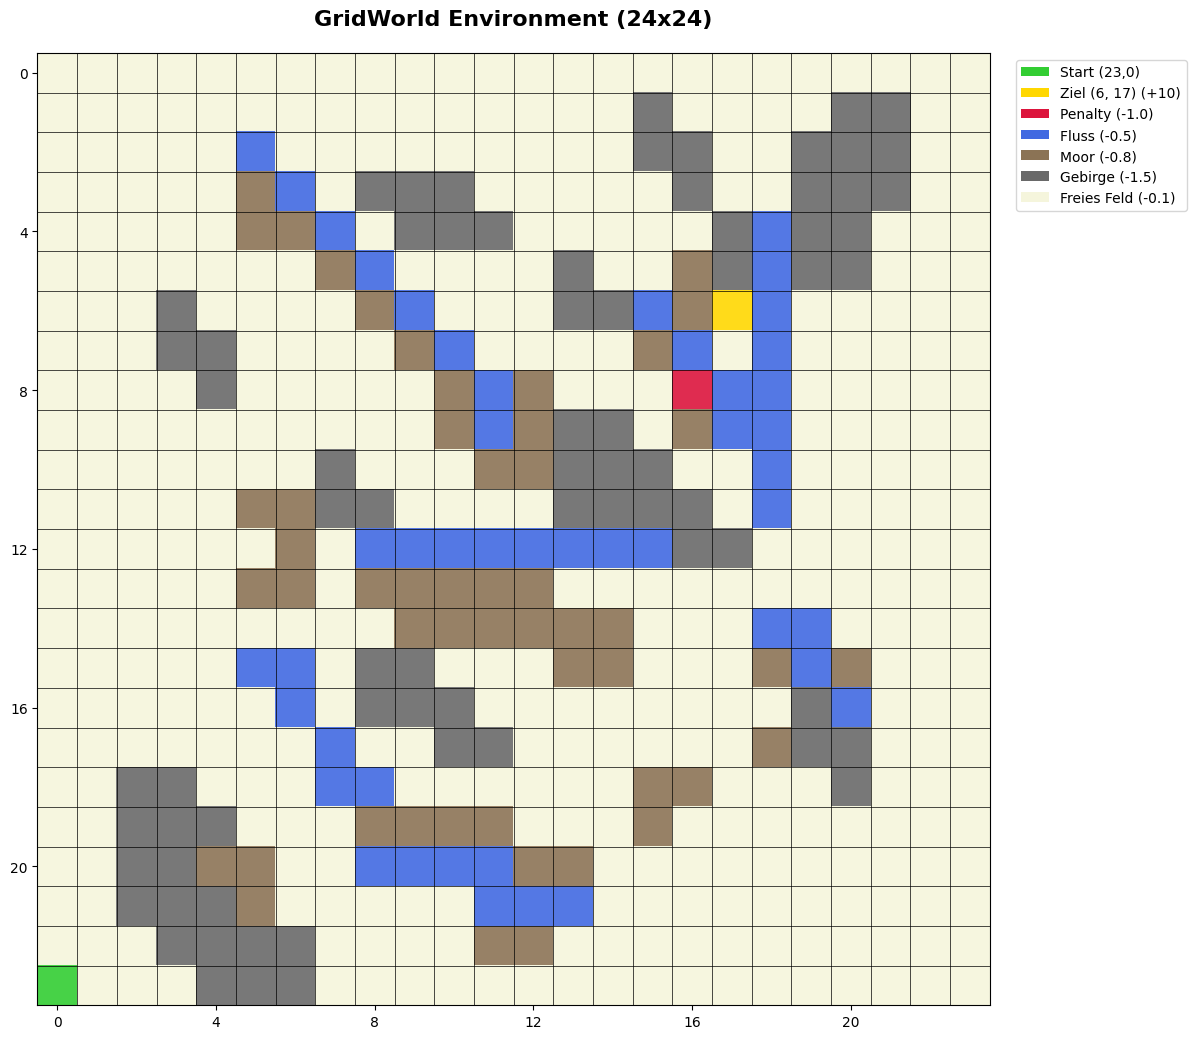

In [131]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def visualize_environment(environment, agent=None, path_states=None):
    """
    Visualisiert das GridEnvironment mit Hindernissen, Landmarks und optionalem Pfad.
    
    Args:
        environment: GridEnvironment Instanz
        agent: QLearningAgent (optional) - wenn angegeben, werden Q-Werte visualisiert
        path_states: Liste von States für optimalen Pfad (optional)
    """
    # Größere Figur für 24x24 Grid
    figsize = max(12, environment.shape[0] * 0.5)
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    
    # Grid-Matrix erstellen
    grid = np.zeros(environment.shape)
    
    # Legende-Elemente
    legend_elements = []
    
    # Hindernisse eintragen
    for obstacle_type, positions in environment.obstacles.items():
        for pos in positions:
            if obstacle_type == "river":
                grid[pos] = 1
            elif obstacle_type == "swamp":
                grid[pos] = 2
            elif obstacle_type == "mountain":
                grid[pos] = 3
    
    # Landmarks eintragen
    if environment.landmarks:
        grid[environment.landmarks[0]] = 4  # Ziel
        if len(environment.landmarks) > 1:
            for penalty_pos in environment.landmarks[1:]:
                if isinstance(penalty_pos, tuple):
                    grid[penalty_pos] = 5  # Penalty
    
    # Startposition
    start_pos = (environment.shape[0] - 1, 0)
    grid[start_pos] = 6
    
    # Farbschema - natürliche Farben für realistische Umgebung
    colors = [
        '#F5F5DC',  # 0: Beige (freies Feld)
        '#4169E1',  # 1: Royalblau (Fluss)
        '#8B7355',  # 2: Braun (Moor)
        '#696969',  # 3: Dunkelgrau (Gebirge)
        '#FFD700',  # 4: Gold (Ziel)
        '#DC143C',  # 5: Rot (Penalty)
        '#32CD32'   # 6: Grün (Start)
    ]
    cmap = ListedColormap(colors)
    
    # Grid visualisieren
    im = ax.imshow(grid, cmap=cmap, vmin=0, vmax=6, alpha=0.9)
    
    # Pfad visualisieren (falls vorhanden)
    if path_states:
        for i in range(len(path_states) - 1):
            y1, x1 = path_states[i]
            y2, x2 = path_states[i + 1]
            
            # Berechne Pfeilgröße basierend auf Grid-Größe
            arrow_scale = 0.3 if environment.shape[0] > 10 else 0.2
            
            ax.arrow(x1, y1, (x2 - x1) * 0.8, (y2 - y1) * 0.8, 
                    head_width=arrow_scale, head_length=arrow_scale * 0.7, 
                    fc='darkgreen', ec='darkgreen', linewidth=2.5, alpha=0.9, zorder=10)
    
    # Q-Werte als Pfeile visualisieren (nur für kleinere Grids sinnvoll)
    if agent and environment.shape[0] <= 12:
        arrow_scale = 0.15
        for i in range(environment.shape[0]):
            for j in range(environment.shape[1]):
                state = (i, j)
                q_values = agent.q_table[state]
                
                # Normalisiere Q-Werte für bessere Visualisierung
                if np.max(q_values) > 0:
                    q_norm = q_values / np.max(np.abs(q_values))
                else:
                    q_norm = q_values
                
                # Zeichne Pfeile für jede Aktion
                actions_coords = {
                    0: (0, -arrow_scale),      # up
                    1: (0, arrow_scale),       # down
                    2: (-arrow_scale, 0),      # left
                    3: (arrow_scale, 0)        # right
                }
                
                for action_idx, (dx, dy) in actions_coords.items():
                    if q_norm[action_idx] > 0.1:  # Nur signifikante Q-Werte
                        alpha = min(0.8, q_norm[action_idx])
                        ax.arrow(j, i, dx * q_norm[action_idx], dy * q_norm[action_idx],
                               head_width=0.1, head_length=0.08,
                               fc='purple', ec='purple', alpha=alpha, linewidth=1)
    
    # Grid-Linien
    ax.set_xticks(np.arange(-0.5, environment.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, environment.shape[0], 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", size=0)
    
    # Achsenbeschriftung - nur jede 2. oder 4. Position für größere Grids
    tick_step = 1 if environment.shape[0] <= 10 else (2 if environment.shape[0] <= 16 else 4)
    ax.set_xticks(np.arange(0, environment.shape[1], tick_step))
    ax.set_yticks(np.arange(0, environment.shape[0], tick_step))
    ax.set_xticklabels(np.arange(0, environment.shape[1], tick_step))
    ax.set_yticklabels(np.arange(0, environment.shape[0], tick_step))
    
    # Legende erstellen mit aktualisierten TERRAIN_COSTS
    legend_elements = [
        mpatches.Patch(facecolor='#32CD32', label=f'Start ({start_pos[0]},{start_pos[1]})'),
        mpatches.Patch(facecolor='#FFD700', label=f'Ziel {environment.landmarks[0]} (+{GOAL_REWARD})'),
        mpatches.Patch(facecolor='#4169E1', label=f'Fluss ({TERRAIN_COSTS["river"]})'),
        mpatches.Patch(facecolor='#8B7355', label=f'Moor ({TERRAIN_COSTS["swamp"]})'),
        mpatches.Patch(facecolor='#696969', label=f'Gebirge ({TERRAIN_COSTS["mountain"]})'),
        mpatches.Patch(facecolor='#F5F5DC', label=f'Freies Feld ({TERRAIN_COSTS["free"]})')
    ]
    
    if len(environment.landmarks) > 1:
        legend_elements.insert(2, mpatches.Patch(facecolor='#DC143C', label='Penalty (-1.0)'))
    
    if path_states:
        legend_elements.append(mpatches.Patch(facecolor='darkgreen', label='Optimaler Pfad'))
    
    if agent and environment.shape[0] <= 12:
        legend_elements.append(mpatches.Patch(facecolor='purple', label='Q-Werte (Pfeile)'))
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
    
    ax.set_title(f'GridWorld Environment ({environment.shape[0]}x{environment.shape[1]})', 
                 fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

# Environment visualisieren
visualize_environment(env)

### Environment mit Q-Werten und optimalem Pfad

Optimaler Pfad von (23, 0) zum Ziel (6, 17):
Anzahl Schritte: 42
Pfad: [(23, 0), (22, 0), (21, 0), (20, 0), (19, 0), (18, 0), (17, 0), (16, 0), (15, 0), (14, 0), (13, 0), (12, 0), (11, 0), (10, 0), (9, 0), (8, 0), (7, 0), (6, 0), (5, 0), (4, 0), (3, 0), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (3, 11), (3, 12), (4, 12), (4, 13), (4, 14), (5, 14), (5, 15), (6, 15), (6, 16), (6, 17)]

Aktionen: ['up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'down', 'right', 'down', 'right', 'right', 'down', 'right', 'down', 'right', 'right']

Gesamtkosten des Pfades: -5.70
Finale Belohnung am Ziel: +10
Netto-Reward: 4.30

Durchquerte Felder:
  Freie Felder: 39 (Kosten: -3.90)
  Flüsse: 2 (Kosten: -1.00)
  Moore: 1 (Kosten: -0.80)
  Gebirge: 0 (Kosten: -0.00)

Visualisierun

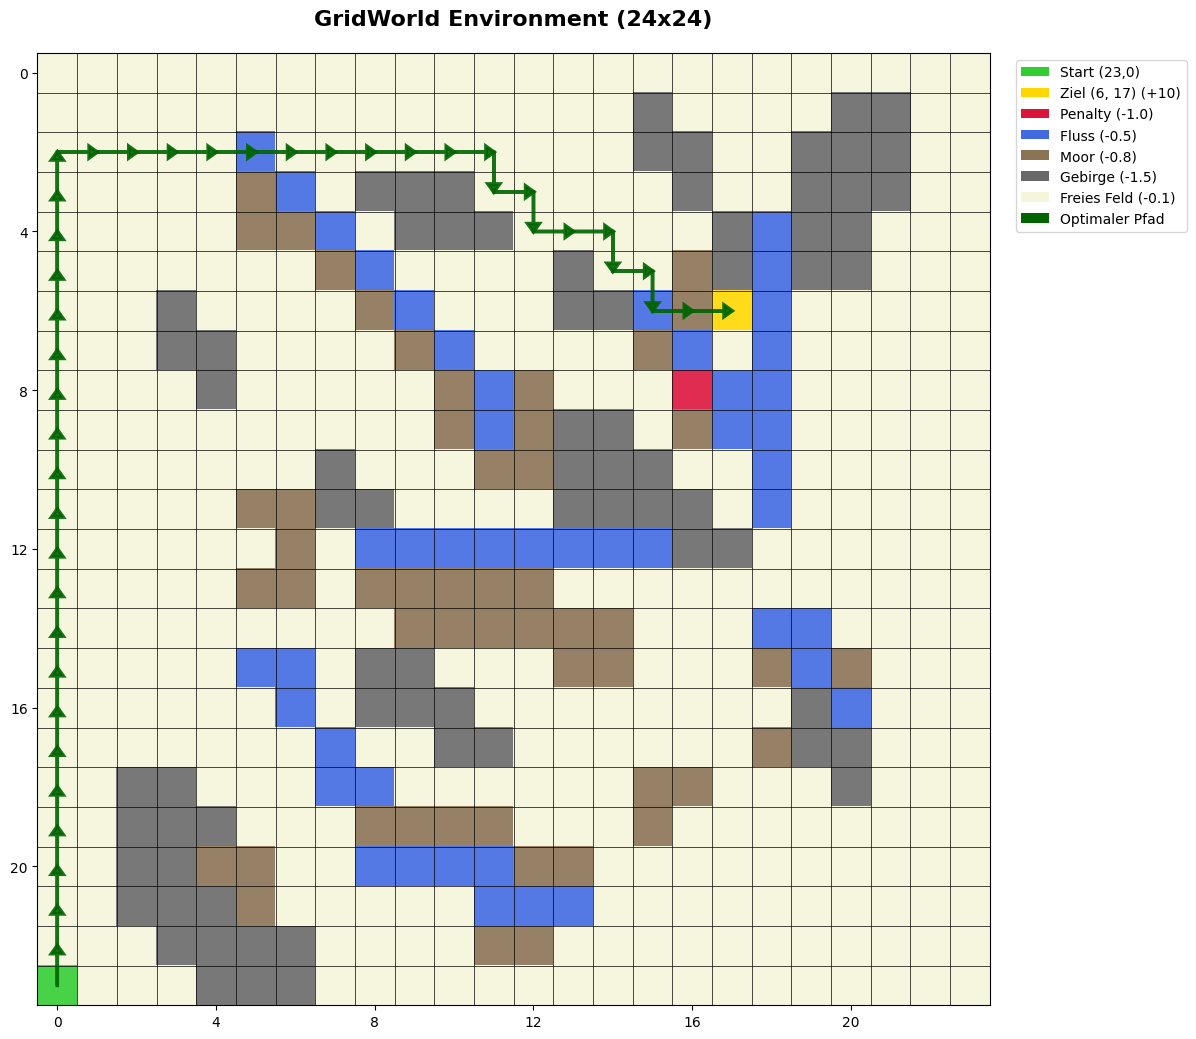

In [132]:
# Optimalen Pfad berechnen
start_pos = (env.shape[0] - 1, 0)  # Start unten links
states, actions = agent.path(state=start_pos)
print(f"Optimaler Pfad von {start_pos} zum Ziel {env.landmarks[0]}:")
print(f"Anzahl Schritte: {len(states) - 1}")
print(f"Pfad: {states}")
print(f"\nAktionen: {actions}")

# Berechne Gesamtkosten des Pfades
total_cost = 0
for state in states[:-1]:  # Letzter State ist das Ziel
    env.state = state
    reward = env.give_reward()
    total_cost += reward

print(f"\nGesamtkosten des Pfades: {total_cost:.2f}")
print(f"Finale Belohnung am Ziel: +{GOAL_REWARD}")
print(f"Netto-Reward: {total_cost + GOAL_REWARD:.2f}")

# Analysiere welche Hindernisse durchquert wurden
obstacles_crossed = {"river": 0, "swamp": 0, "mountain": 0, "free": 0}
for state in states[:-1]:
    if state in env.obstacles.get("river", []):
        obstacles_crossed["river"] += 1
    elif state in env.obstacles.get("swamp", []):
        obstacles_crossed["swamp"] += 1
    elif state in env.obstacles.get("mountain", []):
        obstacles_crossed["mountain"] += 1
    else:
        obstacles_crossed["free"] += 1

print(f"\nDurchquerte Felder:")
print(f"  Freie Felder: {obstacles_crossed['free']} (Kosten: {obstacles_crossed['free'] * TERRAIN_COSTS['free']:.2f})")
print(f"  Flüsse: {obstacles_crossed['river']} (Kosten: {obstacles_crossed['river'] * TERRAIN_COSTS['river']:.2f})")
print(f"  Moore: {obstacles_crossed['swamp']} (Kosten: {obstacles_crossed['swamp'] * TERRAIN_COSTS['swamp']:.2f})")
print(f"  Gebirge: {obstacles_crossed['mountain']} (Kosten: {obstacles_crossed['mountain'] * TERRAIN_COSTS['mountain']:.2f})")

# Environment mit Agent und Pfad visualisieren
print("\n" + "="*50)
print("Visualisierung des optimalen Pfades...")
print("="*50)
visualize_environment(env, agent=None, path_states=states)

In [133]:
states, actions = agent.path(state=(2, 1))
print("Optimal path to goal:", states)
print("Optimale moves from state to goal:", actions)

Optimal path to goal: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (3, 11), (3, 12), (4, 12), (4, 13), (4, 14), (5, 14), (5, 15), (6, 15), (6, 16), (6, 17)]
Optimale moves from state to goal: ['right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'right', 'down', 'right', 'down', 'right', 'right', 'down', 'right', 'down', 'right', 'right']
